In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import nltk
import string

In [3]:
train = pd.read_csv("train_F3WbcTw.csv")
test = pd.read_csv("test_tOlRoBf.csv")

In [4]:
train_original=train.copy()
test_original=test.copy()

In [5]:
combi = train.append(test, ignore_index=True)
combi.shape

(8203, 4)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5279 entries, 0 to 5278
Data columns (total 4 columns):
unique_hash    5279 non-null object
text           5279 non-null object
drug           5279 non-null object
sentiment      5279 non-null int64
dtypes: int64(1), object(3)
memory usage: 165.0+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2924 entries, 0 to 2923
Data columns (total 3 columns):
unique_hash    2924 non-null object
text           2924 non-null object
drug           2924 non-null object
dtypes: object(3)
memory usage: 68.6+ KB


In [8]:
combi.groupby('sentiment').describe()

drug                       text         \
          count unique      top freq count unique   
sentiment                                           
0.0         617     57  ocrevus  112   617    617   
1.0         837     54  gilenya  236   837    837   
2.0        3825     97  ocrevus  455  3825   3727   

                                                                  unique_hash  \
                                                         top freq       count   
sentiment                                                                       
0.0        @hamdog , it’s a choice between a pill, that y...    1         617   
1.0        I recently changed from Gilenya to Tysabri due...    1         837   
2.0        The  lungs are a pair of cone-shaped breathing...    3        3825   

                                                                 
          unique                                       top freq  
sentiment                                                        
0.0          617  25c3e2e69e9c3fdb6d86d6f123ce111e695ccf3e    1  
1.0          837  a5b937ffb4d7bf33239cda85fc0436541084f2d6    1  
2.0         3825  316591c31fc120d540b961d4dbe9343bf670b0c1    1

In [9]:
combi['length']=combi['text'].apply(len)

In [10]:
combi.head()

,drug,sentiment,text,unique_hash,length
0,gilenya,2.0,Autoimmune diseases tend to come in clusters. ...,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,404
1,gilenya,2.0,I can completely understand why you’d want to ...,9eba8f80e7e20f3a2f48685530748fbfa95943e4,1184
2,fingolimod,2.0,Interesting that it only targets S1P-1/5 recep...,fe809672251f6bd0d986e00380f48d047c7e7b76,780
3,ocrevus,2.0,"Very interesting, grand merci. Now I wonder wh...",bd22104dfa9ec80db4099523e03fae7a52735eb6,124
4,gilenya,1.0,"Hi everybody, My latest MRI results for Brain ...",b227688381f9b25e5b65109dd00f7f895e838249,612


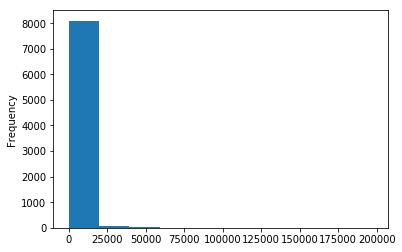

In [15]:
combi['length'].plot(kind='hist') 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C50F1D0>,
      dtype=object)

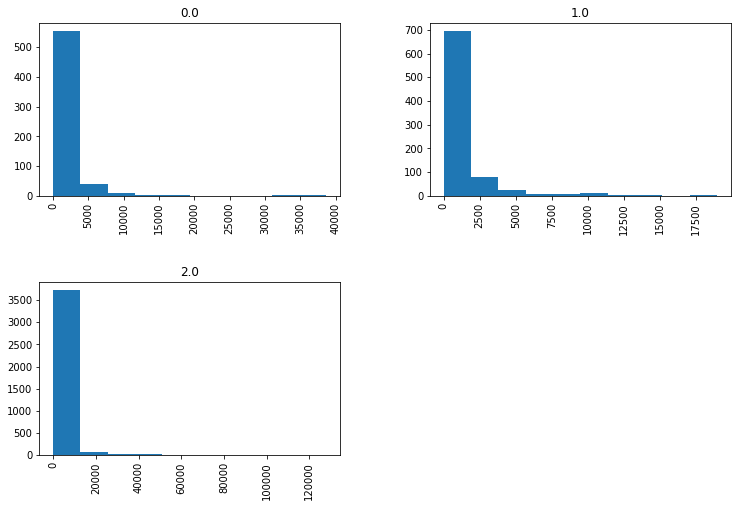

In [17]:
combi.hist(column='length', by='sentiment',figsize=(12,8))

In [18]:
from nltk.corpus import stopwords

In [19]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [20]:
combi['text'].apply(text_process)

0       [Autoimmune, diseases, tend, come, clusters, G...
1       [completely, understand, you’d, want, try, res...
2       [Interesting, targets, S1P15, receptors, rathe...
3       [interesting, grand, merci, wonder, lemtrada, ...
4       [Hi, everybody, latest, MRI, results, Brain, C...
5       [can’t, give, advice, Lemtrada, chose, Cladrib...
6       [Reply, posted, JessZidek, Hi, Jess, Sorry, re...
7       [Well, expected, Neurologist, wants, start, Ty...
8       [think, FIngolimod, miserable, failure, progre...
9       [Thank, much…I’m, learning, lot, GRACE, mentio...
10      [vision, one, eye, unrelated, eye, injections,...
11      [significant, bleeding, right, eye, need, lase...
12      [Objective, review, evidence, supporting, Euro...
13      [Multiple, sclerosis, MS, thought, inflammator...
14      [Mom’s, diagnosis, similar, Mine, detected, Ja...
15      [Humira, adalimumab, injectable, protein, anti...
16      [Well, theory, GI, telling, accurate, standard...
17      [goodn

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(combi['text'])


print(len(bow_transformer.vocabulary_))

76219


In [23]:
messages_bow = bow_transformer.transform(combi['text'])

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [25]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(8203, 76219)


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [74]:
train_bow = messages_bow[:5279,:]
test_bow = messages_bow[5279:,:]

In [108]:
xtrain, xtest, ytrain, ytest = train_test_split(train_bow, train['sentiment'],test_size=0.3)

In [76]:
lreg = LogisticRegression()
lreg.fit(xtrain, ytrain) 

prediction = lreg.predict_proba(xtest) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int)

f1_score(ytest, prediction_int,average = 'macro')

0.18706060951867184

In [77]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['sentiment'] = test_pred_int
submission = test[['unique_hash','sentiment']]
submission.to_csv('inno_log.csv', index=False)

In [78]:
from sklearn import svm

In [79]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain, ytrain)

prediction = svc.predict_proba(xtest)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(ytest, prediction_int,average = 'macro')

0.11641317935591405

In [80]:
test_pred = svc.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['sentiment'] = test_pred_int
submission = test[['unique_hash','sentiment']]
submission.to_csv('nlp_svm.csv', index=False)

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
rf = RandomForestClassifier().fit(xtrain, ytrain)

prediction = rf.predict(xtest)
f1_score(ytest, prediction,average = 'macro')

0.3212864934025118

In [83]:
test_pred = rf.predict(test_bow)
test['sentiment'] = test_pred
submission = test[['unique_hash','sentiment']]
submission.to_csv('inno_rf.csv', index=False)

In [84]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(xtrain,ytrain)

In [85]:
prediction = mnb.predict(xtest)
f1_score(ytest,prediction,average = 'macro')

0.354584692627304

In [86]:
test_pred = mnb.predict(test_bow)
test['sentiment'] = test_pred
submission = test[['unique_hash','sentiment']]
submission.to_csv('inno_mnb.csv', index=False)

In [105]:
from sklearn.ensemble import AdaBoostClassifier

In [117]:
clf = AdaBoostClassifier(base_estimator = mnb)

In [118]:
clf.fit(xtrain,ytrain)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [119]:
prediction = clf.predict(xtest)
f1_score(ytest,prediction,average = 'macro')

0.28540604373774175

In [111]:
test_pred = clf.predict(test_bow)
test['sentiment'] = test_pred
submission = test[['unique_hash','sentiment']]
submission.to_csv('inno_ada.csv', index=False)

In [149]:
train_tfidf = messages_tfidf[:5279,:]
test_tfidf = messages_tfidf[5279:,:]

In [150]:
xtrain, xtest, ytrain, ytest = train_test_split(train_tfidf, train['sentiment'],test_size=0.3)

In [151]:
lreg = LogisticRegression()
lreg.fit(xtrain, ytrain) 

prediction = lreg.predict_proba(xtest) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int)

f1_score(ytest, prediction_int,average = 'macro')

0.15779717125679238

In [152]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain, ytrain)

prediction = svc.predict_proba(xtest)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(ytest, prediction_int,average = 'macro')

0.19040844479679586

In [153]:
rf = RandomForestClassifier().fit(xtrain, ytrain)

prediction = rf.predict(xtest)
f1_score(ytest, prediction,average = 'macro')

0.34035924085056385

In [154]:
test_pred = rf.predict(test_bow)
test['sentiment'] = test_pred
submission = test[['unique_hash','sentiment']]
submission.to_csv('inno_rf_tfidf.csv', index=False)

In [155]:
mnb = MultinomialNB().fit(xtrain,ytrain)

prediction = mnb.predict(xtest)
f1_score(ytest,prediction,average = 'macro')

0.2792858889704084

In [156]:
clf = AdaBoostClassifier()

In [157]:
clf.fit(xtrain,ytrain)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [158]:
prediction = clf.predict(xtest)
f1_score(ytest,prediction,average = 'macro')

0.400147233703958

In [159]:
test_pred = clf.predict(test_bow)
test['sentiment'] = test_pred
submission = test[['unique_hash','sentiment']]
submission.to_csv('inno_ada_tfidf.csv', index=False)

In [132]:
bow_transformer = CountVectorizer().fit(combi['text'])


print(len(bow_transformer.vocabulary_))

47960


In [133]:
messages_bow = bow_transformer.transform(combi['text'])

In [134]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [135]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(8203, 47960)


In [136]:
train_bow = messages_bow[:5279,:]
test_bow = messages_bow[5279:,:]

In [137]:
xtrain, xtest, ytrain, ytest = train_test_split(train_bow, train['sentiment'],test_size=0.3)

In [138]:
lreg = LogisticRegression()
lreg.fit(xtrain, ytrain) 

prediction = lreg.predict_proba(xtest) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int)

f1_score(ytest, prediction_int,average = 'macro')

0.18548392563594152

In [139]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['sentiment'] = test_pred_int
submission = test[['unique_hash','sentiment']]
submission.to_csv('inno_log.csv', index=False)

In [140]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain, ytrain)

prediction = svc.predict_proba(xtest)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(ytest, prediction_int,average = 'macro')

0.09434427057041898

In [141]:
rf = RandomForestClassifier().fit(xtrain, ytrain)

prediction = rf.predict_proba(xtest)
f1_score(ytest, prediction,average = 'macro')

0.31716872150570824

In [143]:
test_pred = rf.predict(test_bow)
test['sentiment'] = test_pred
submission = test[['unique_hash','sentiment']]
submission.to_csv('inno_rf.csv', index=False)

In [145]:
mnb = MultinomialNB().fit(xtrain,ytrain)

prediction = mnb.predict(xtest)
f1_score(ytest,prediction,average = 'macro')

0.40150693776681484

In [146]:
test_pred = mnb.predict(test_bow)
test['sentiment'] = test_pred
submission = test[['unique_hash','sentiment']]
submission.to_csv('inno_mnb.csv', index=False)

In [147]:
clf = AdaBoostClassifier().fit(xtrain,ytrain)

prediction = clf.predict(xtest)
f1_score(ytest,prediction,average = 'macro')

0.358811267468099

In [148]:
test_pred = clf.predict(test_bow)
test['sentiment'] = test_pred
submission = test[['unique_hash','sentiment']]
submission.to_csv('inno_ada.csv', index=False)

In [169]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', AdaBoostClassifier()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [161]:
xtrain, xtest, ytrain, ytest = train_test_split(train['text'], train['sentiment'],test_size=0.3)

In [170]:
pipeline.fit(xtrain,ytrain)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000000000C3FB598>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...m='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])

In [171]:
prediction = pipeline.predict(xtest)
f1_score(ytest,prediction,average = 'macro')

0.3886708184140151

In [172]:
test_pred = clf.predict(test_bow)
test['sentiment'] = test_pred
submission = test[['unique_hash','sentiment']]
submission.to_csv('inno_pipe.csv', index=False)

In [173]:
test_pred = clf.predict(test_tfidf)
test['sentiment'] = test_pred
submission = test[['unique_hash','sentiment']]
submission.to_csv('inno_pipe.csv', index=False)